# `Inside the Offshores leak`
`Panama Papers as you have never seen it`
***


# Research Question 4
> ##### There is a hypothesis that scandals involving tax havens actually help to promote creating offshores there. 
See for example [International Strategic Analysis](http://www.isa-world.com/news/?tx_ttnews%5BbackPid%5D=1&tx_ttnews%5Btt_news%5D=198&cHash=10b412a7de63d3b2a02adf0d120a09f6). Can we find evidence for this in the data?

## Most important leaks
Here is a list of the most important leaks documented by the International Consortium of Investigative Journalists [ICIJ](https://offshoreleaks.icij.org/)
- ##### Bahamas Leak 
April 2, 2013
None got scared [Best year =  2010]
- ##### China Leak ⭐️
January 21, 2014
More offshores [Seyschelles - Samoa - British Virgin Islands - British Anguila] 
- ##### Lux Leak 
December 9, 2014
None got scared [Best year =  2007]
- ##### Swiss Leak 
February 8, 2015 
None got scared [Best year =  2007]
- ##### Panama Leak
April 3, 2016 

### Importing libs
___

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#Import new style
plt.style.use('bmh')

In [3]:
from utils import visualizer, preprocessing

### Loading csv files

In [4]:
entities = r'./panama_csv/Entities.csv'
entities = pd.read_csv(entities,index_col='name', header=0, low_memory=False)
entities=entities.rename(columns = {'countries':'Country'})

## Getting the most involved countries/jurisdictions.
___
From the Entities dataset we select:
- **15 most involved countries**, on which we compute our analysis. Those countries are the countries that have the highest number of offshores accounts in tax haven jurisdictions.
- **5 most involved jurisdictions**, on which we compute our analysis. Those jurisdictions are the jurisdictions that are managing / managed the highest registered number of offshores accounts worldwide.

### What do we do?

For each of the most involved countries/jurisdictions we analyze how much are they involved and what's their behavior throughout the years. 

1. We define how much each jurisdiction is involved by looking at how many offshores accounts are registered in it.
2. We define how much those countries are involved by looking at how many offshores accounts are registered from this country as country of origin.

It's important to note that we want to look also at the number of **new incorporations** - **inactivations** and **active offshores** for every year.

The number of new incorporations as the number of inactivations for each year is easily derived by the dataset since for each account there it's registered the date of incorporation as the one of inactivation. 
The number of actives offshores in one year is easily computed with a simple algorithm given the dates above.

### Why?

To state wheter one scandals has visible worldwide consequences we must base our analysis on the number of, in this way analyzing:
- **new incorporations**, this number can give us the proof is one scandal actually acted as a marketing tool, inviting people of one specific **COUNTRY** to invest in offshores account in one specific tax haven **JURISDICTION**.
- **inactivations**, this number can give us the proof is one scandal scared people in one specific **COUNTRY** that are actually investing in one specific tax haven **JURISDICTION**.

We are also interested to look at key events or particular years where the global market has undergone a major change. To do this we will look at the behavior of the most involved countries throughout the years, how they invested, how much and in which jurisdictions.

## Further assumptions.
We must note that all the following results are based on a fraction of the whole real data, which is the only available and emerged. We can consider the eventual results realistics since the data we are analyzing contains a good amount of data. However we cannot exclude that further scandals can obviously revert them.
### Getting most involved countries and jurisdictions
___
We group by __Country/Jurisdiction__, we count the elements sorting by **node_id** which represent the unique id of each offshore account.

In [5]:
most_involved = entities.groupby('Country').count().sort_values('node_id', ascending=False).head(15).index
most_involved = most_involved[most_involved!='Not identified']
most_involved_countries = []
for involved in most_involved:
    if involved == 'British Virgin Islands':
        name = 'Virgin Islands (British)'
    elif involved == 'United Kingdom':
        name = 'United Kingdom of Great Britain and Northern Ireland'
    else:
        name = involved
    most_involved_countries.append(name)

In [6]:
most_involved_jur = entities.groupby('jurisdiction_description').count().sort_values('node_id', ascending=False).head().index
most_involved_jur = most_involved_jur[most_involved_jur!='Undetermined']
most_involved_jur

Index(['Bahamas', 'British Virgin Islands', 'Panama', 'Seychelles'], dtype='object', name='jurisdiction_description')

## Preprocessing dataset
___
We process the entity dataframe to obtain a new dataframe that maps the flows of **inactivations**, **incorporations**, **actives** offshores for each year from one **country** to each **jurisdiction**.

The structure of the new dataframe is composed in this way:
- **jurisdiction**, the name of the jurisdiction where the offshore account is opened.
- **Country**, the name of the origin country of the offshore account.
- **date**, the year that the entry is considering.
- **action**, wheter we are counting incorporations/inactivations/active offshores/strucks off offshores in the specific date described above
- **offshores**, the number directly related to the field action described above in the specific year.

In [7]:
countries_frame = preprocessing.process_countries(entities=entities, first_involved_countries=most_involved, analisys_on='jurisdiction', from_year=1980, to_year=2016)

In [8]:
countries_frame[0].sort_values('date', ascending=False).head()

,Country,date,action,offshores
jurisdiction,,,,
Seychelles,Hong Kong,2016,strucks,37.0
Hong Kong,Hong Kong,2016,strucks,1.0
Bahamas,Hong Kong,2016,active offshores,203.0
Bahamas,Hong Kong,2016,strucks,3.0
British Anguilla,Hong Kong,2016,active offshores,1059.0


## Visualizing situation in the most involved countries

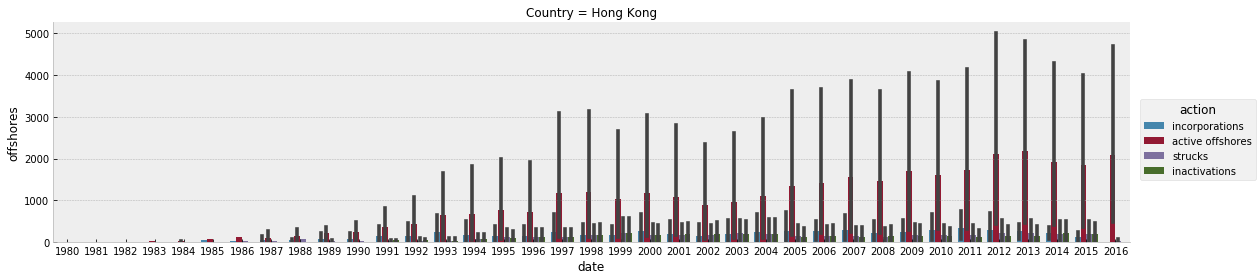

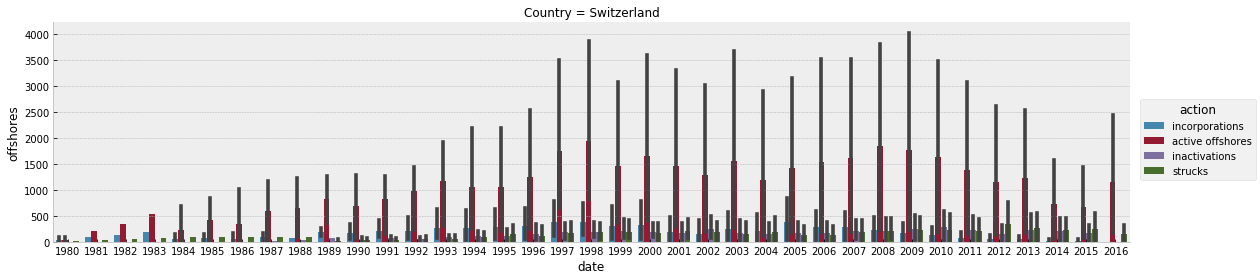

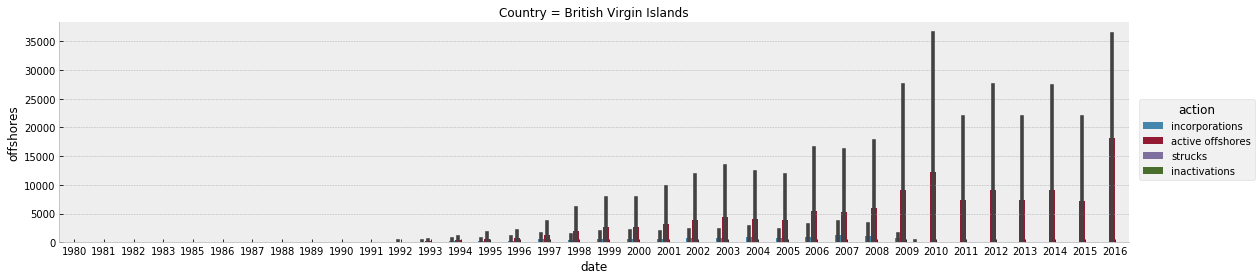

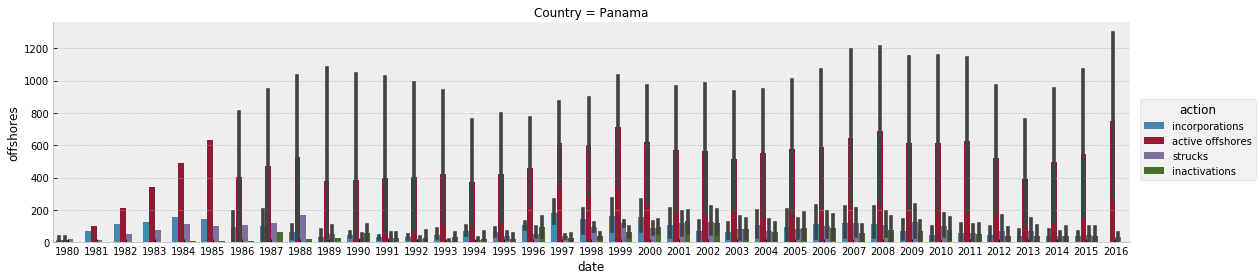

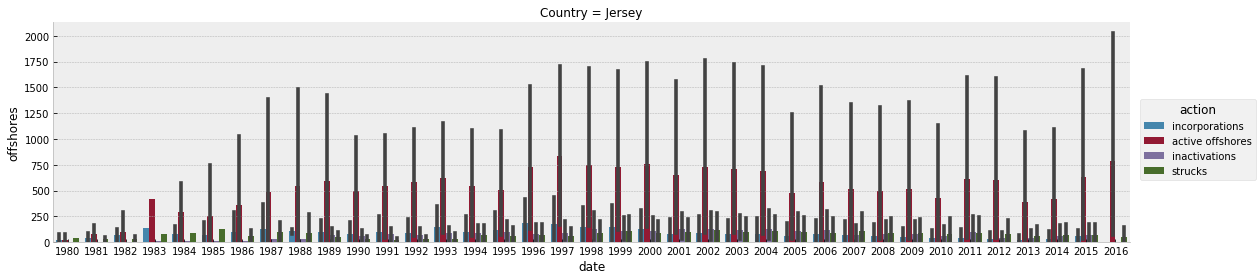

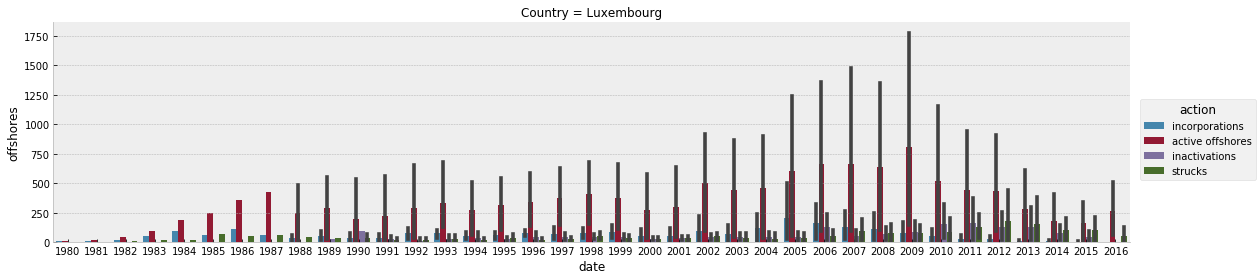

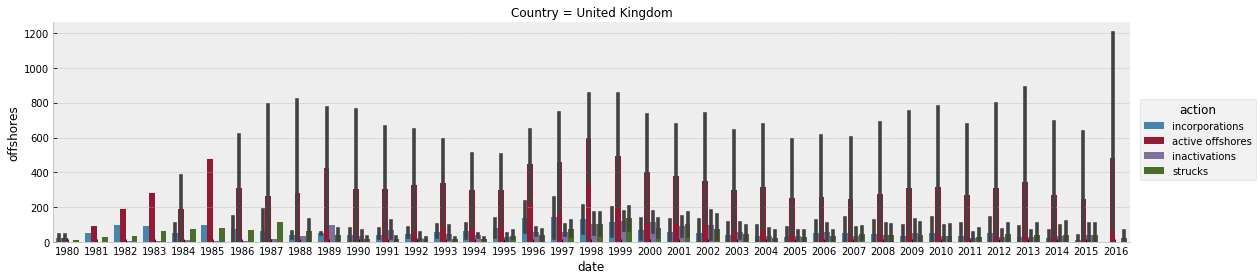

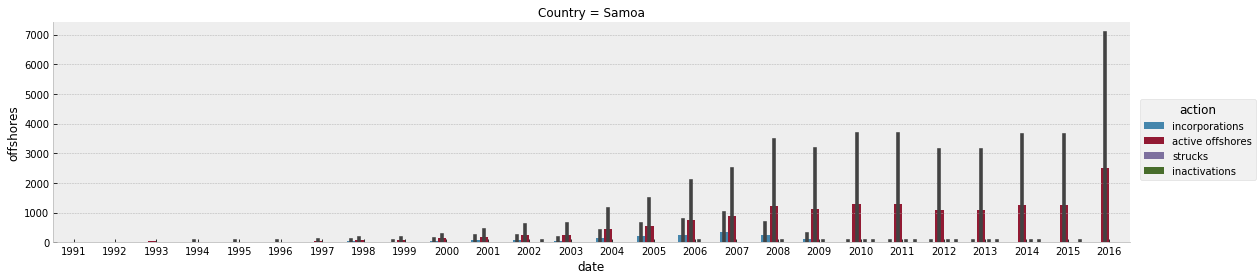

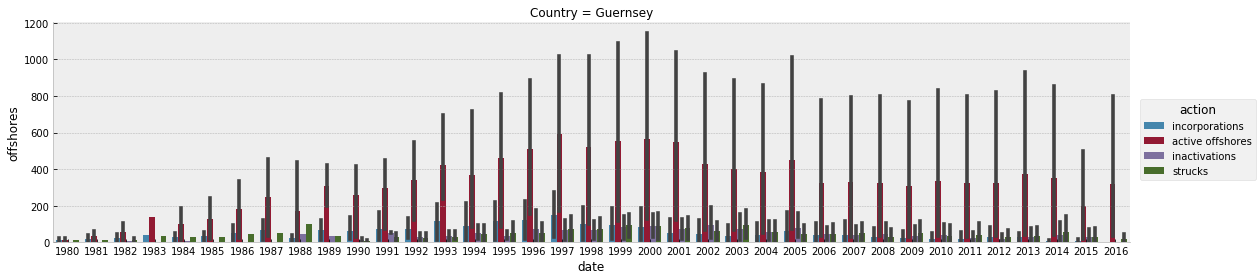

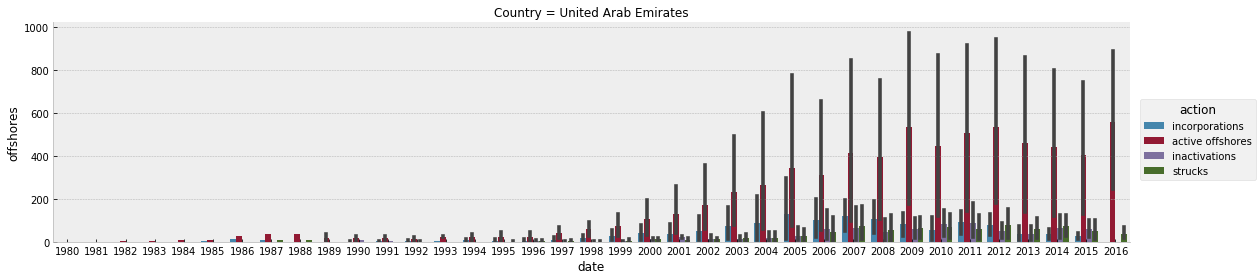

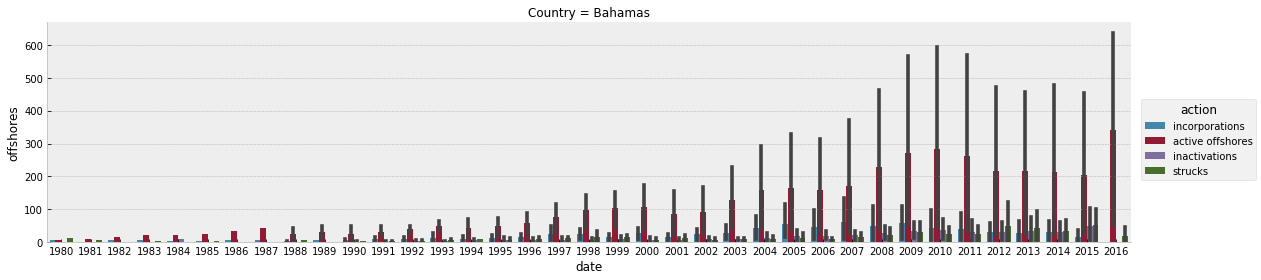

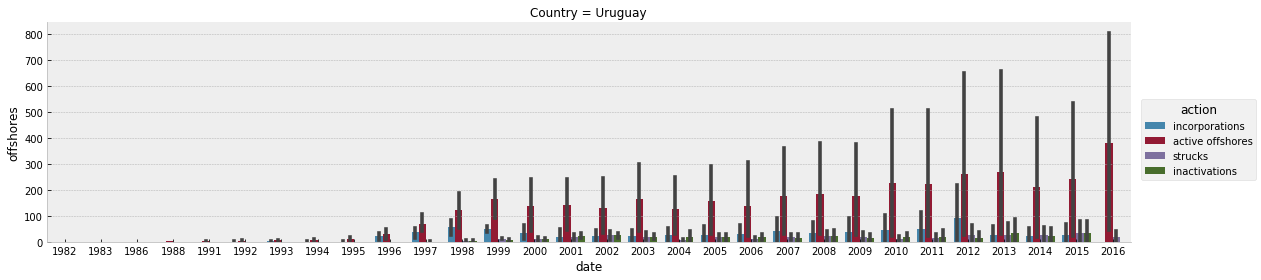

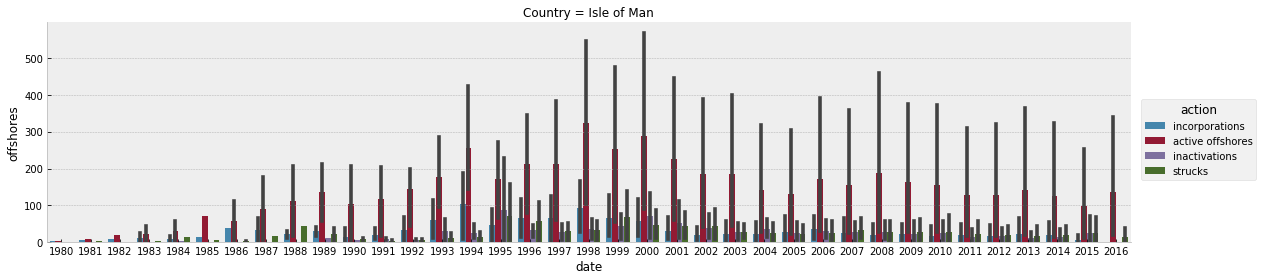

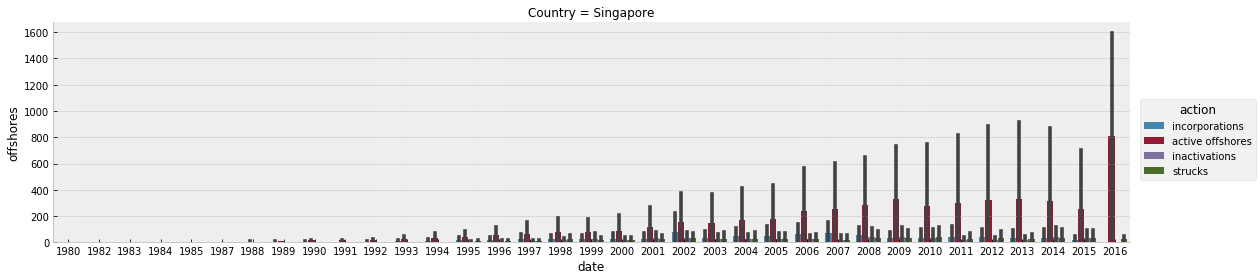

In [9]:
visualizer.visualize_countries_situation(countries_frame, divide_by='Country')

## Visualizing situation in the most involved jurisdictions
___
#### British Virgin Islands


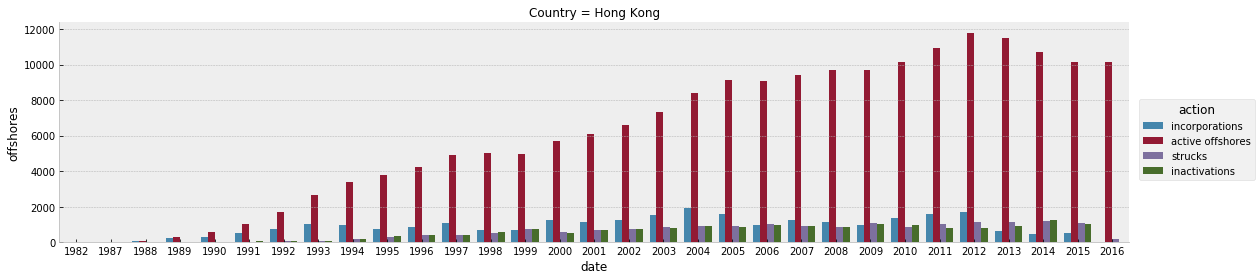

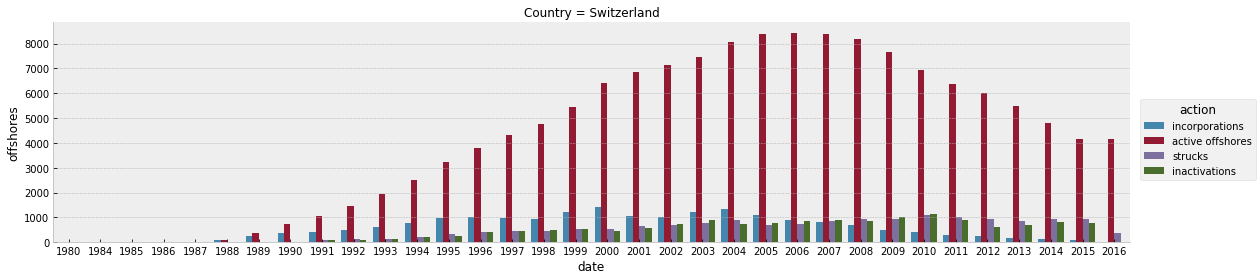

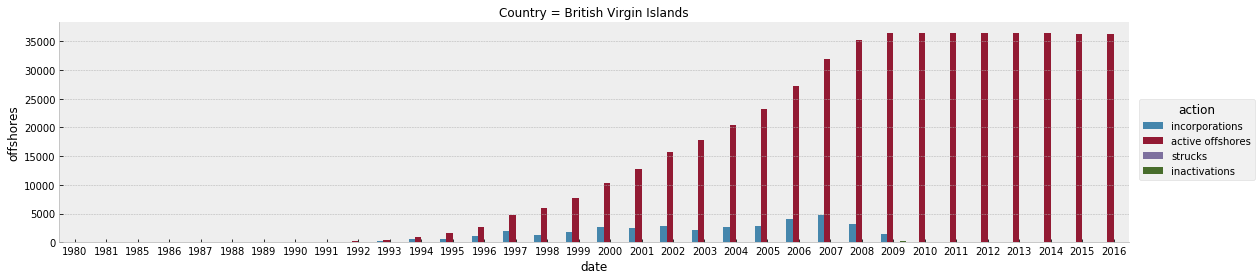

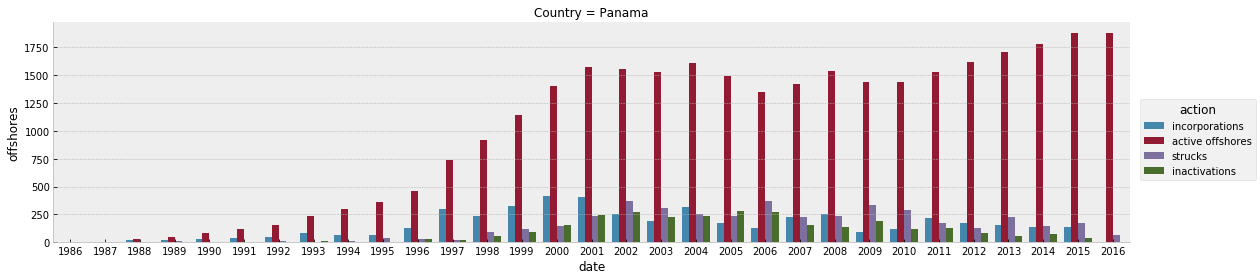

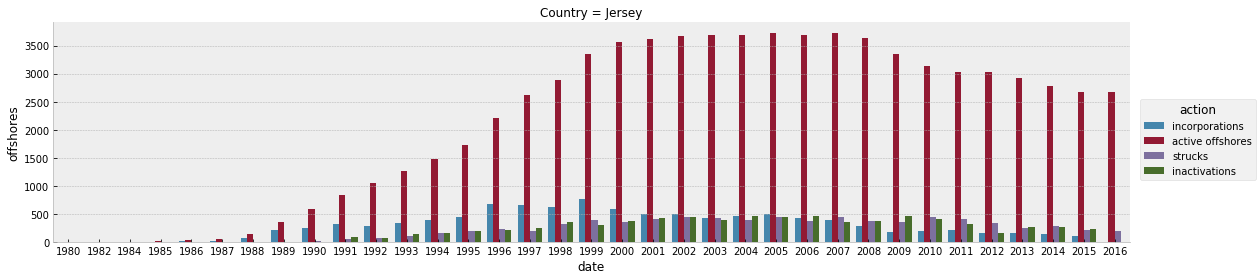

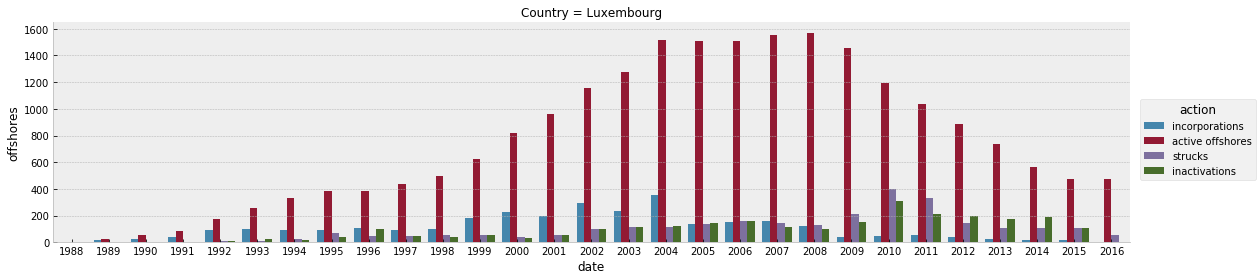

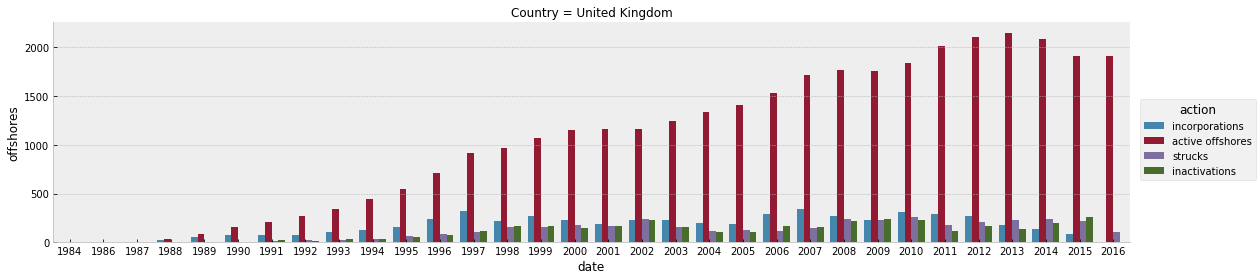

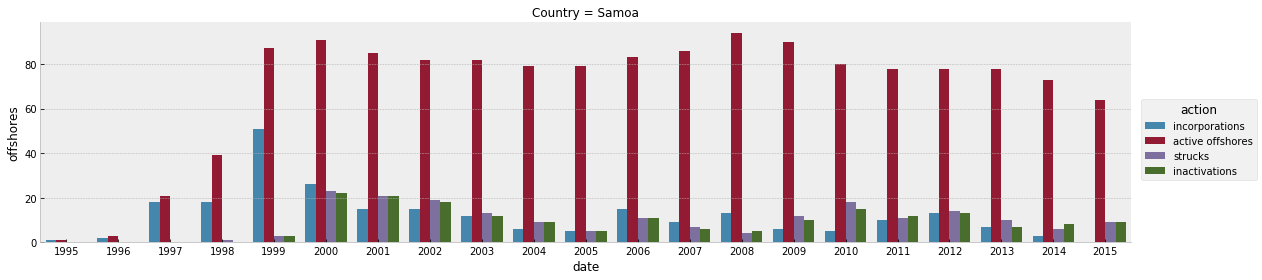

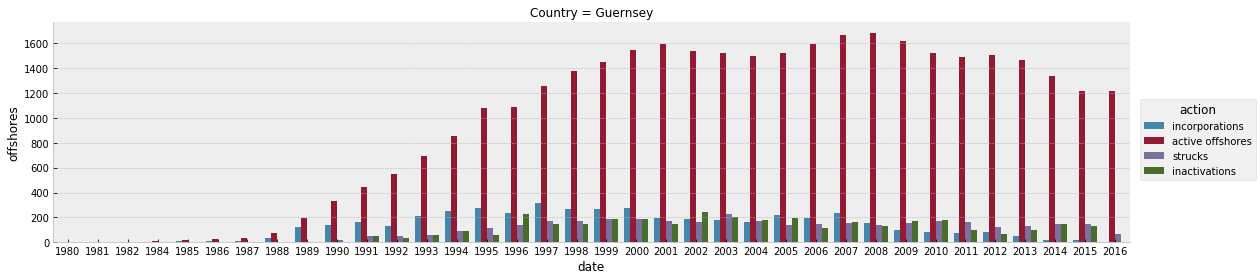

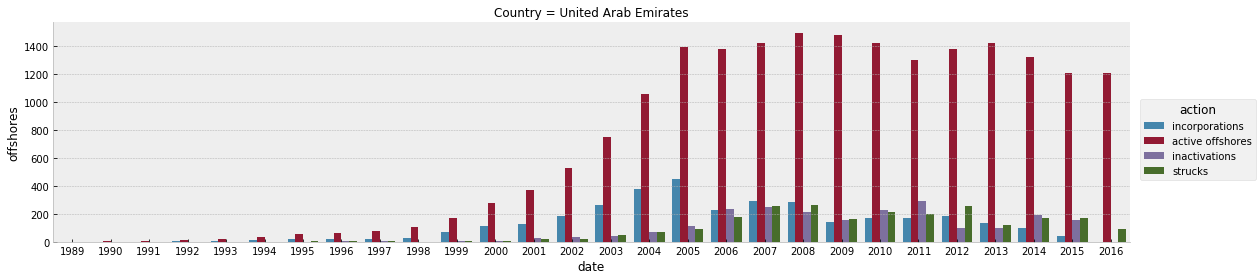

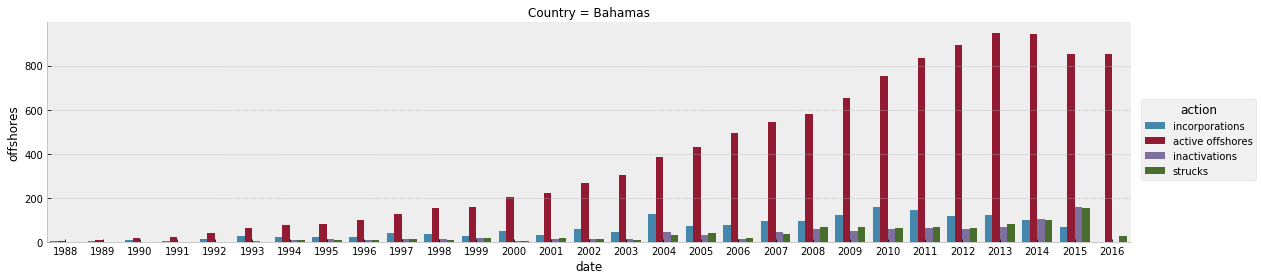

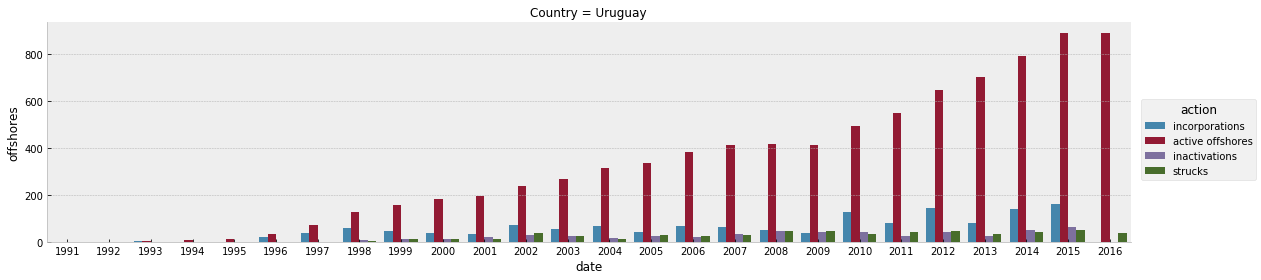

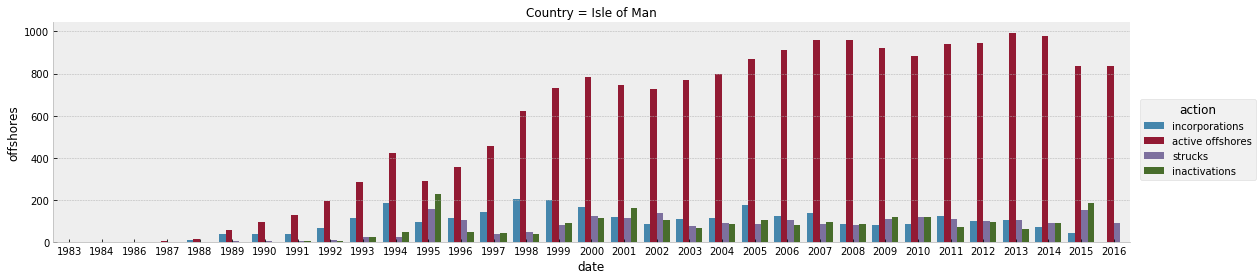

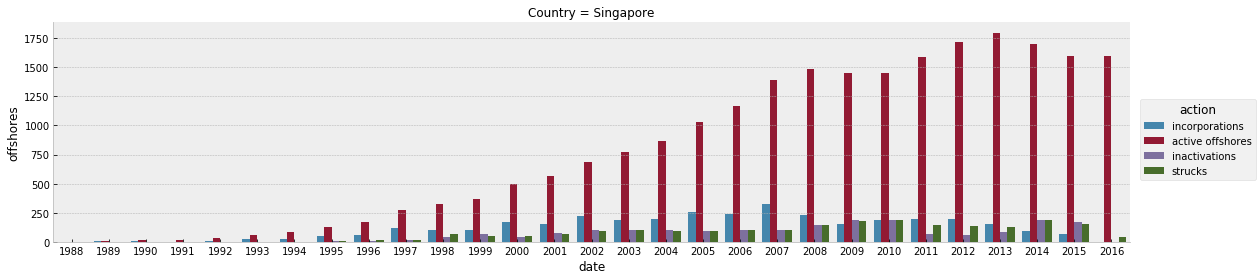

In [10]:
visualizer.visualize_countries_situation(countries_frame, divide_by='Country',selected_jurisdiction='British Virgin Islands')

#### Panama

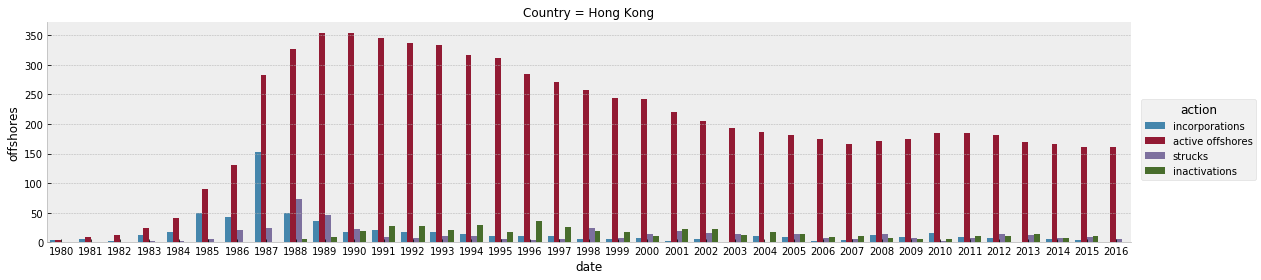

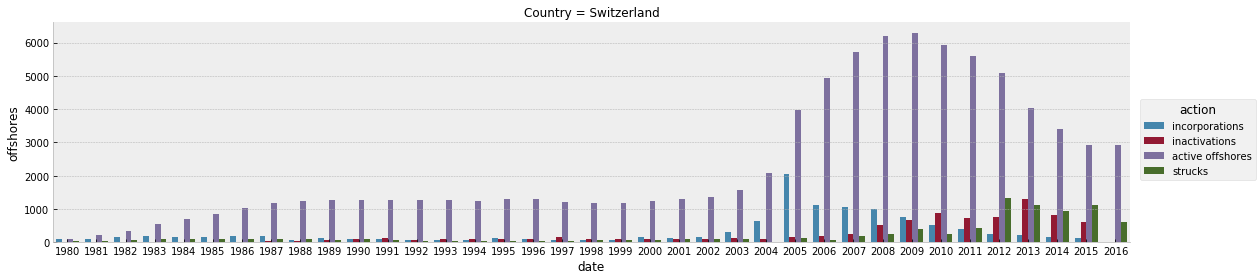

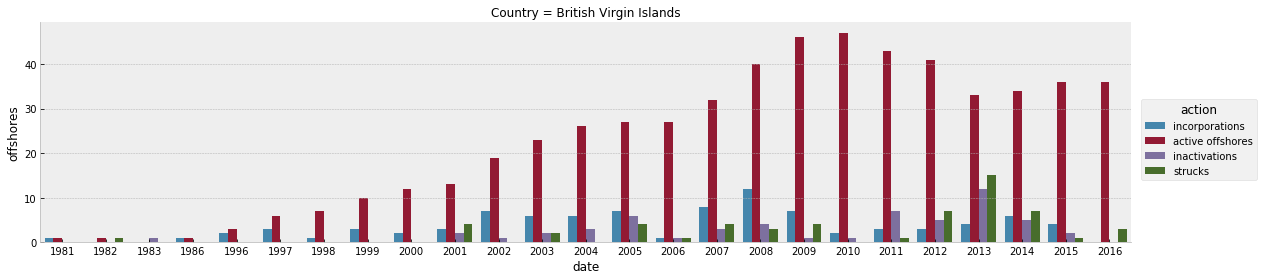

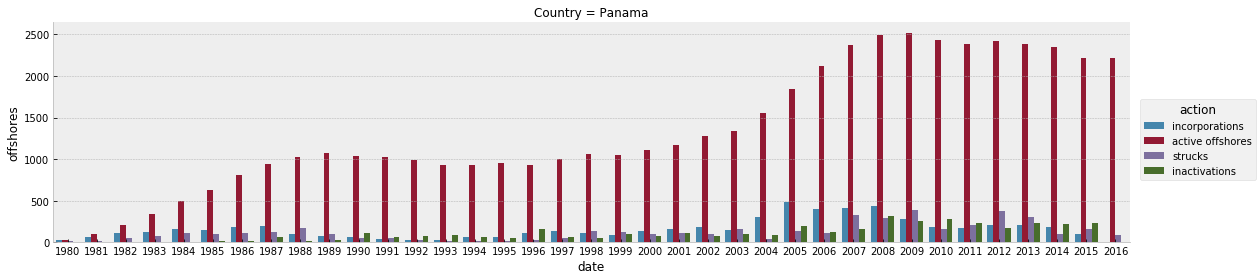

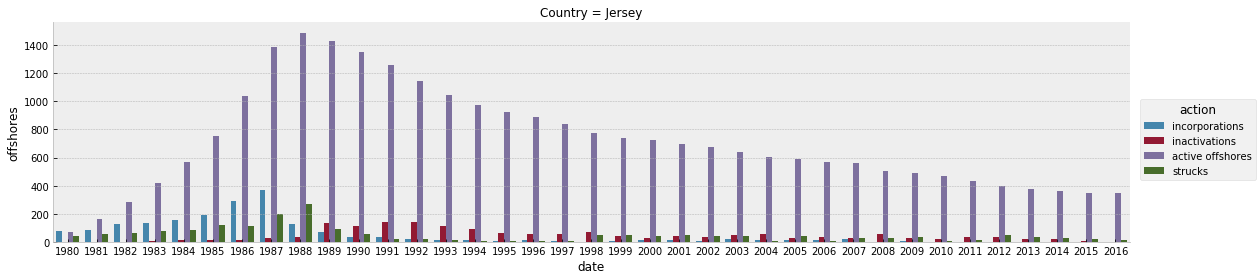

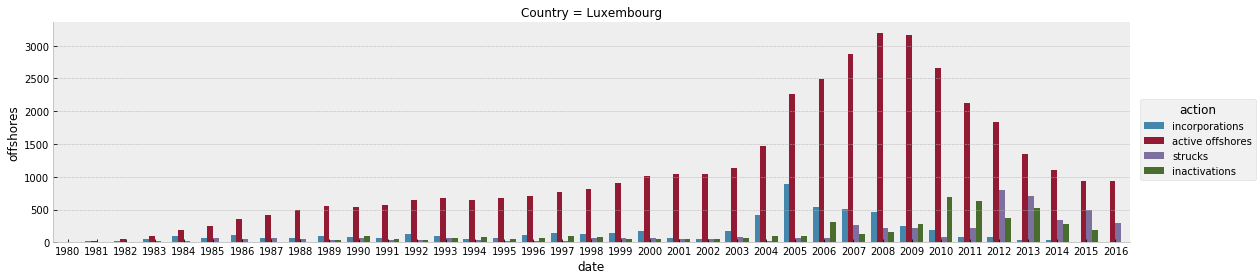

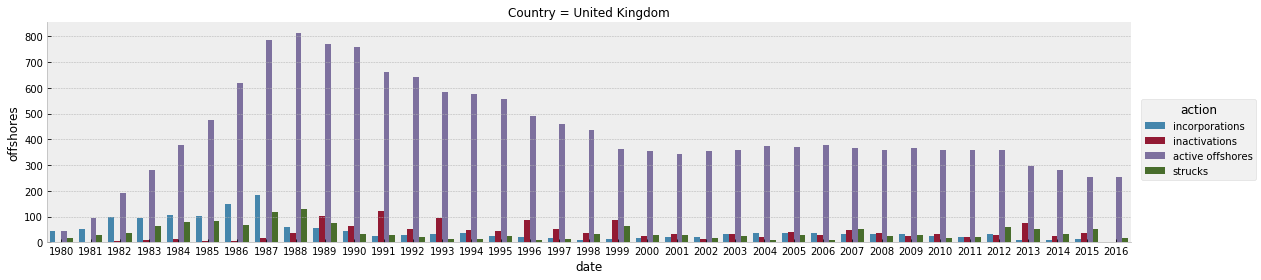

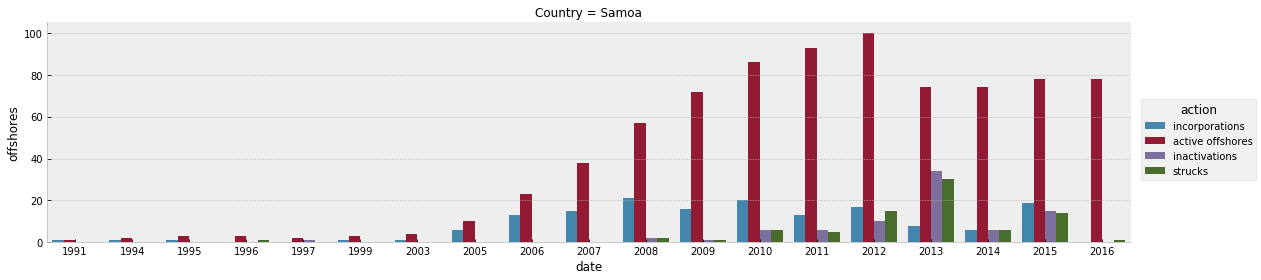

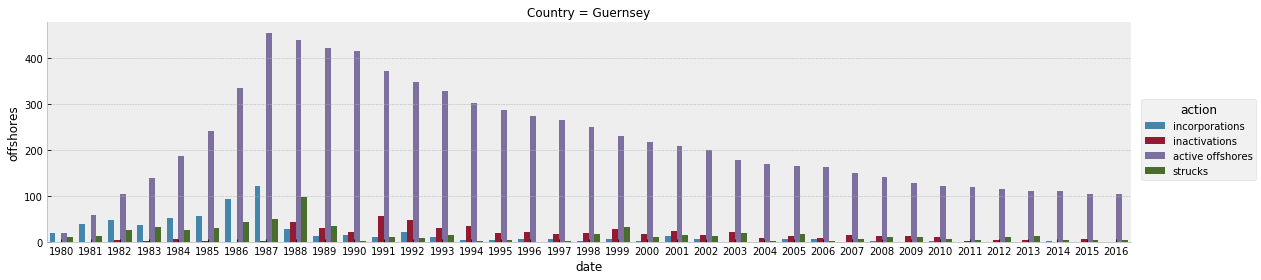

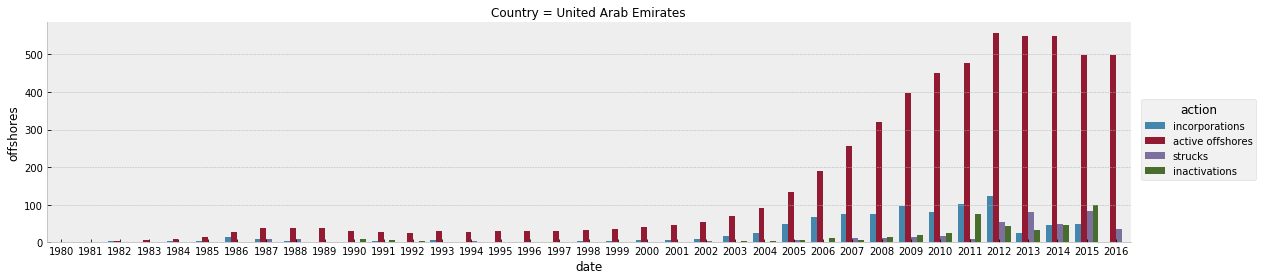

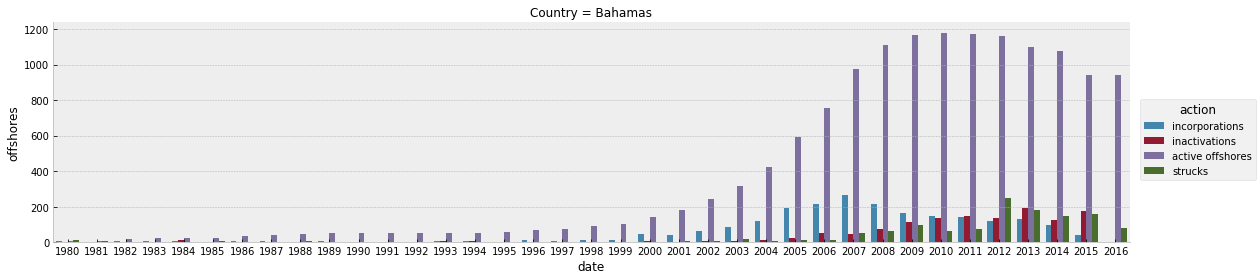

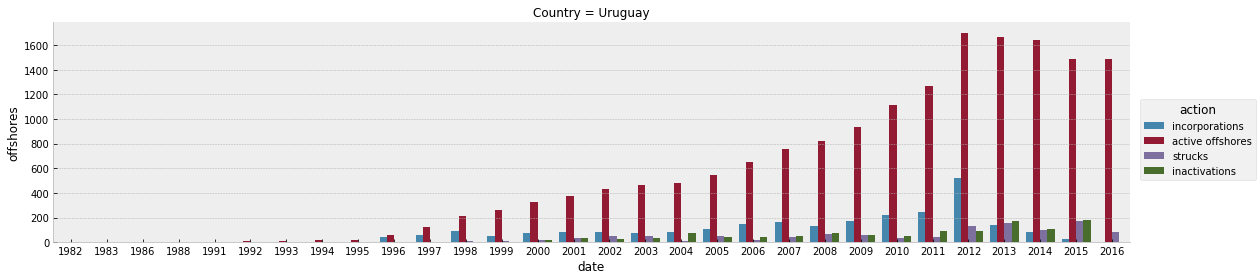

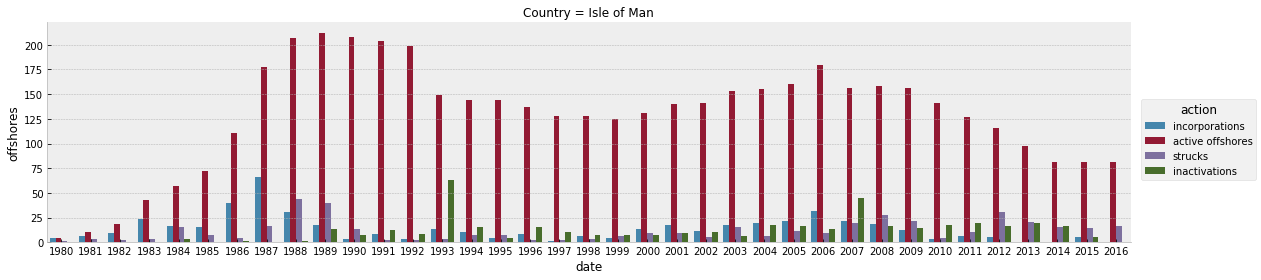

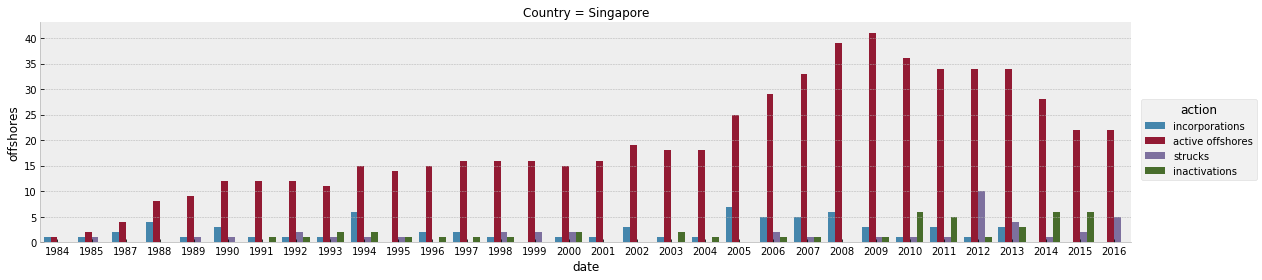

In [11]:
visualizer.visualize_countries_situation(countries_frame, divide_by='Country',selected_jurisdiction='Panama')

## Visualize flows with interactive map and pie chart.
___

### How to use it?

The [interactive widget](http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html) provided by Jupyter notebook is used in this visualization to select one of the most involved countries.

Given one country it's possible to see its flow of _incorporations_, _inactivations_, _actives_ offshores in one specific year which is selectable with a bounded slider.

**Note**: The flow is represented by red arcs throughout the map. The opacity of each arc represent its weight over the total.

The Pie chart below displays the composition of the given flows in the specific country for each involved jurisdiction in that specific year.



In [12]:
interactive(visualizer.visualizeFlowByCountry, country=most_involved_countries, year=(1950, 2016, 1), feat=['actives', 'incorporations','inactivations'])## Observations

A Jupyter Widget

## Observations

### Most important leaks
Here is a list of the most important leaks documented by the International Consortium of Investigative Journalists [ICIJ](https://offshoreleaks.icij.org/)
- **Bahamas Leak**
April 2, 2013
None got scared [Best year =  2010]
- **China Leak** ⭐️
January 21, 2014
More offshores [Seyschelles - Samoa - British Virgin Islands - British Anguila] 
- **Lux Leak** 
December 9, 2014
None got scared [Best year =  2007]
- **Swiss Leak** 
February 8, 2015 
None got scared [Best year =  2007]
- **Panama Leak**
April 3, 2016

#### Too early to state something clear, we will investigate the percentages for each country in each jurisdiction.
___

## Save CSV
This function is used to create the CSV used for the visualization. 

__No need to run it again since are already created and accessible__.

In [ ]:
entities = r'./panama_csv/Entities.csv'
entities = pd.read_csv(entities,index_col='name', header=0, low_memory=False)
entities=entities.rename(columns = {'countries':'Country','jurisdiction':'abbr_jurisd','jurisdiction_description':'jurisdiction'})
all_countries = entities.groupby('Country').count().index
features = ['active offshores', 'incorporations', 'inactivations']
for feature in features:
    frame = preprocessing.process_countries_with_code(entities, 
                                                            all_countries, 
                                                            analisys_on='Country', 
                                                            from_year=1900, 
                                                            to_year=2017,
                                                            feature=feature
                                                           )
    name = feature
    if name == 'active offshores':
        name = 'actives'
    frame.to_csv('csv/cash_flows_'+name+'.csv', index=False)

## Other further ideas

> ### [How much money do you need in order to make an offshore account worthwhile ?](http://www.macleans.ca/news/world/why-do-the-rich-hide-money-offshore-anyway/)
> ### The [Financial Secrecy Index](http://www.financialsecrecyindex.com/introduction/fsi-2015-results) can be useful to investigate differences between tax haven jurisdictions.